<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2024/blob/main/Heteroscedastic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
# Generate synthetic data
np.random.seed(42)
x = np.linspace(0, 10, 100)
true_y = 2 * np.cos(x) + 1
noise_std = 0.5 * np.sin(x) + 1  # Non-uniform noise
noise = np.random.normal(0, noise_std)
y = true_y + noise

# Convert to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [52]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc1add = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc1add(x)
        x = self.relu(x)
        x = self.fc1add(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class HeteroscedasticRegression(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(HeteroscedasticRegression, self).__init__()
        self.mean_model = MLP(input_dim, hidden_dim, 1)
        self.log_std_model = MLP(input_dim, hidden_dim, 1)

    def forward(self, x):
        mean = self.mean_model(x)
        log_std = self.log_std_model(x)
        std = torch.exp(log_std)
        return mean, std

In [53]:
def heteroscedastic_loss(y_pred, y_true, std):
    return torch.mean(0.5 * torch.log(2 * np.pi * std**2) + ((y_true - y_pred)**2) / (2 * std**2))

In [54]:
# Initialize the model, optimizer, and loss function
input_dim = 1
hidden_dim = 20
model = HeteroscedasticRegression(input_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    mean_pred, std_pred = model(x_tensor)
    loss = heteroscedastic_loss(mean_pred, y_tensor, std_pred)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [100/10000], Loss: 1.4539
Epoch [200/10000], Loss: 1.3870
Epoch [300/10000], Loss: 1.3446
Epoch [400/10000], Loss: 1.2977
Epoch [500/10000], Loss: 1.2483
Epoch [600/10000], Loss: 1.2678
Epoch [700/10000], Loss: 1.2479
Epoch [800/10000], Loss: 3.7956
Epoch [900/10000], Loss: 1.3686
Epoch [1000/10000], Loss: 1.3470
Epoch [1100/10000], Loss: 1.3308
Epoch [1200/10000], Loss: 1.3204
Epoch [1300/10000], Loss: 1.3146
Epoch [1400/10000], Loss: 1.3097
Epoch [1500/10000], Loss: 1.3050
Epoch [1600/10000], Loss: 1.3035
Epoch [1700/10000], Loss: 1.2979
Epoch [1800/10000], Loss: 1.2961
Epoch [1900/10000], Loss: 1.2961
Epoch [2000/10000], Loss: 1.2918
Epoch [2100/10000], Loss: 1.2922
Epoch [2200/10000], Loss: 1.2901
Epoch [2300/10000], Loss: 1.2881
Epoch [2400/10000], Loss: 1.2922
Epoch [2500/10000], Loss: 1.2867
Epoch [2600/10000], Loss: 1.2924
Epoch [2700/10000], Loss: 1.2888
Epoch [2800/10000], Loss: 1.2795
Epoch [2900/10000], Loss: 1.2793
Epoch [3000/10000], Loss: 1.2784
Epoch [3100/10000],

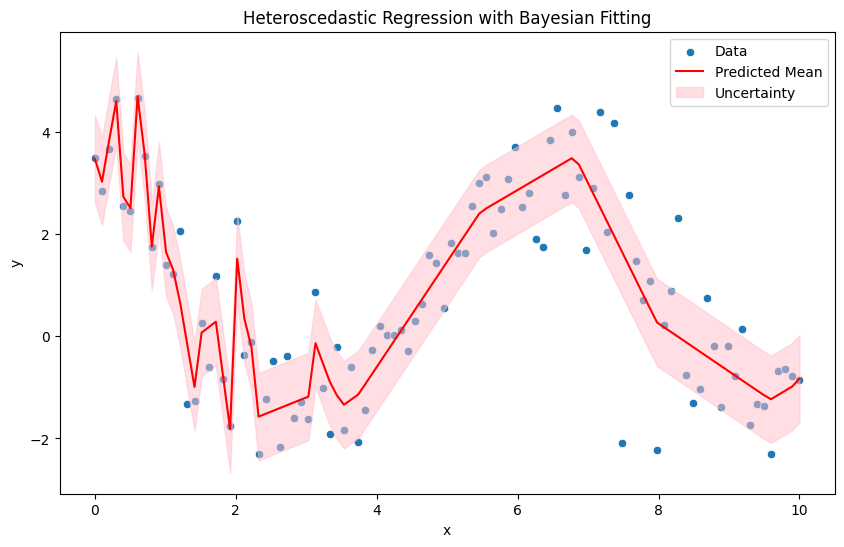

In [55]:
# Evaluate the model
model.eval()
with torch.no_grad():
    mean_pred, std_pred = model(x_tensor)

# Convert to numpy arrays
mean_pred = mean_pred.squeeze().numpy()
std_pred = std_pred.squeeze().numpy()

# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, label='Data')
sns.lineplot(x=x, y=mean_pred, color='red', label='Predicted Mean')
plt.fill_between(x, mean_pred - std_pred, mean_pred + std_pred, color='pink', alpha=0.5, label='Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heteroscedastic Regression with Bayesian Fitting')
plt.legend()
plt.show()